Problema a tiempo directo
\begin{align}
-\partial_t \varphi - \gamma \Delta \varphi = v \chi_O, \quad \Omega,\\
\varphi = 0, \quad \partial \Omega \times (0, \tau),\\
\varphi(x, \tau) = \varphi_0, \quad \Omega,\\
\varphi(x, 0) = 0, \quad \Omega
\end{align}

Problema a tiempo inverso: $\Phi(x, t) = \varphi(x, \tau - t)$
\begin{align}
\partial_t \Phi - \gamma \Delta \Phi = v \chi_O, \quad \Omega,\\
\Phi = 0, \quad \partial \Omega \times (0, \tau),\\
\Phi(x, 0) = \varphi_0, \quad \Omega,\\
|| \Phi(x, \tau) || < \epsilon, \quad \Omega
\end{align}

In [1]:
tau = 0.5

In [2]:
from dolfin import *
from dolfin_adjoint import *
import numpy as np
set_log_level(LogLevel.WARNING)

In [3]:
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "Lagrange", 1)
tol = 1e-14
# Defining bounday conditions

def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS
uD = Constant(0.0)
bc = DirichletBC(V, uD, boundary)

In [4]:
ind_O = interpolate(Expression('1/3 <= x[1] <= 2/3 ? 0.0 : 1.0', degree=4), V)

In [32]:
phi0 = Function(V, '../step_0/Eigenfunction_1.xml')

In [33]:
# Resolving the variational formulation    
dt = 0.0025

# u0 = interpolate(u0_opt, V)
u0 = interpolate(Expression("0.0", degree=4), V)
u = u0.copy(deepcopy=True)

phi_prev = phi0.copy(deepcopy=True) 
phi_next = phi0.copy(deepcopy=True) 

T = tau
t = 0.0
v = TestFunction(V)

states = [phi0.copy(deepcopy=True)]
controls = [u0.copy(deepcopy=True) ]
times = [float(t)]
timestep = 0

In [34]:
while abs(T-t)>=tol :
    print("Solving for t == %s" % (t + dt))
#     u.assign(u0, annotate=True)
    
    F = inner((phi_next - phi_prev) / Constant(dt), v) * dx + inner(grad(phi_next), grad(v)) * dx - (u * ind_O) * v * dx
    solve(F == 0, phi_next, bc, annotate=True) # This is how dolfin-adjoint records the dependency of the control in each timestep
    
    phi_prev.assign(phi_next, annotate=True)
    
    t += dt
    timestep += 1
    
    states.append(phi_next.copy(deepcopy=True, annotate=True))
#     controls.append(u.copy(deepcopy=True, annotate=True))
    
    times.append(float(t))
    print("Done!")

Solving for t == 0.0025
Done!
Solving for t == 0.005
Done!
Solving for t == 0.0075
Done!
Solving for t == 0.01
Done!
Solving for t == 0.0125
Done!
Solving for t == 0.015000000000000001
Done!
Solving for t == 0.0175
Done!
Solving for t == 0.02
Done!
Solving for t == 0.0225
Done!
Solving for t == 0.024999999999999998
Done!
Solving for t == 0.027499999999999997
Done!
Solving for t == 0.029999999999999995
Done!
Solving for t == 0.032499999999999994
Done!
Solving for t == 0.034999999999999996
Done!
Solving for t == 0.0375
Done!
Solving for t == 0.04
Done!
Solving for t == 0.0425
Done!
Solving for t == 0.045000000000000005
Done!
Solving for t == 0.04750000000000001
Done!
Solving for t == 0.05000000000000001
Done!
Solving for t == 0.05250000000000001
Done!
Solving for t == 0.055000000000000014
Done!
Solving for t == 0.057500000000000016
Done!
Solving for t == 0.06000000000000002
Done!
Solving for t == 0.06250000000000001
Done!
Solving for t == 0.06500000000000002
Done!
Solving for t == 0.0675

Done!
Solving for t == 0.4925000000000004
Done!
Solving for t == 0.4950000000000004
Done!
Solving for t == 0.4975000000000004
Done!
Solving for t == 0.5000000000000003
Done!


In [8]:
import matplotlib.pyplot as plt

In [9]:
# # t = 0
# img = []
# for i in range(100):
#     row = []
#     for j in range(100):
#         row.append(states[t]([i/99,j/99]))
#     img.append(row)
# plt.imshow(img, vmin=0, vmax=2)
# plt.title(t)
# t+=5

In [35]:
len(states)

201

In [11]:
# heat = File("heat.pvd")
# state = Function(V, name="state")
# for i in range(len(states)):
#     si = states[i]
#     state.vector().zero()
#     state.vector().axpy(1, si)
#     heat << state

In [36]:
%%time
steps=len(times)

combined = zip(times,controls)
alpha = Constant(0.5)
# and the minimizing problem
J = assemble(phi_next*phi_next*dx)
m = Control(u)#[Control(c) for c in controls]
RJ = ReducedFunctional(J,m)

u0_opt = minimize(RJ,tol=1.0e-10, options={"ftol": 1e-7})

CPU times: user 17.3 s, sys: 750 ms, total: 18 s
Wall time: 18.5 s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1089     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15015D-21    |proj g|=  6.12140D-15

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1089      0      1      0     0     0   6.121D-15   5.150D-21
  F =   5.1501464101255754E-021

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [41]:
u0_opt([2/3, 2/3])

0.0

In [42]:
u0_opt.rename('u','u')

u0 = interpolate(u0_opt, V)
u = u0.copy(deepcopy=True)

phi_prev = phi0.copy(deepcopy=True) 
phi_next = phi0.copy(deepcopy=True) 

T = tau
t = 0.0
v = TestFunction(V)

states = [phi0.copy(deepcopy=True)]
controls = [u0.copy(deepcopy=True) ]
times = [float(t)]
timestep = 0
file = File('NullControls/sol.pvd')
states[-1].rename('phi','phi')
file << (states[-1], 0)
while abs(T-t)>=tol :
    print("Solving for t == %s" % (t + dt))
    
    F = inner((phi_next - phi_prev) / Constant(dt), v) * dx + inner(grad(phi_next), grad(v)) * dx - (u * ind_O) * v * dx
    solve(F == 0, phi_next, bc, annotate=True) # This is how dolfin-adjoint records the dependency of the control in each timestep
    
    phi_prev.assign(phi_next, annotate=True)
    
    t += dt
    timestep += 1
    
    states.append(phi_next.copy(deepcopy=True, annotate=True))
    
    times.append(float(t))
    states[-1].rename('phi','phi')
    
    file << (states[-1],t)
    
    print("Done!")

Solving for t == 0.0025
Done!
Solving for t == 0.005
Done!
Solving for t == 0.0075
Done!
Solving for t == 0.01
Done!
Solving for t == 0.0125
Done!
Solving for t == 0.015000000000000001
Done!
Solving for t == 0.0175
Done!
Solving for t == 0.02
Done!
Solving for t == 0.0225
Done!
Solving for t == 0.024999999999999998
Done!
Solving for t == 0.027499999999999997
Done!
Solving for t == 0.029999999999999995
Done!
Solving for t == 0.032499999999999994
Done!
Solving for t == 0.034999999999999996
Done!
Solving for t == 0.0375
Done!
Solving for t == 0.04
Done!
Solving for t == 0.0425
Done!
Solving for t == 0.045000000000000005
Done!
Solving for t == 0.04750000000000001
Done!
Solving for t == 0.05000000000000001
Done!
Solving for t == 0.05250000000000001
Done!
Solving for t == 0.055000000000000014
Done!
Solving for t == 0.057500000000000016
Done!
Solving for t == 0.06000000000000002
Done!
Solving for t == 0.06250000000000001
Done!
Solving for t == 0.06500000000000002
Done!
Solving for t == 0.0675

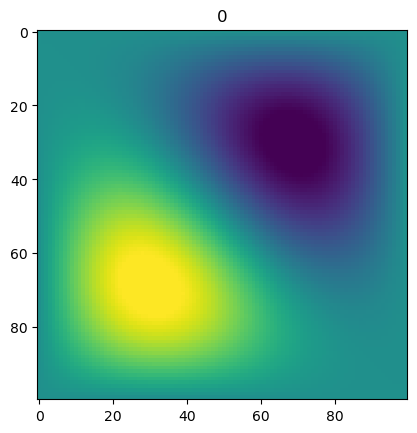

In [57]:
t = 0
img = []
for i in range(100):
    row = []
    for j in range(100):
        row.append(states[t]([i/99,j/99]))
    img.append(row)
plt.imshow(img, vmin=-2, vmax=2)
plt.title(t)
t+=1